<a href="https://colab.research.google.com/github/kgh1997/Dacon_Stock_Prediction_Algorithm/blob/main/BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 경진대회 목적
- 한국거래소는 금융상품의 시세, 공시정보 등 다양한 투자 참고정보를 제공∙판매하고 있습니다.
- (KRX가 제공∙판매하고 있는 주요 투자 참고 정보는 정보데이터시스템(https://data.krx.co.kr) 참고)
- 한국거래소의 정보사업을 확대하고, 시장참가자들에게 더욱 유용한 투자 참고 정보를 제공하기 위해,
- 제2회 KRX 주식 투자 알고리즘 경진대회를 개최합니다.
- 자본시장 데이터 및 공공 데이터를 활용하여 높은 안정성과 수익률을 기대할 수 있는 주식 투자 알고리즘을 만들어주세요.

### 주식거래에 대한 가정
- 참가자들은 포트폴리오에서 지정해준 순위에 따라 거래기간 동안 거래를 진행한다고 가정
- 구체적으로는, 전체 2000주 중 상위 200주와 하위 200주를 선정하여 매일 동일 금액 비중으로 거래를 진행한다고 가정
- 상위 200주에 대해서는 매수 전략(Long)을 취하게 되고, 하위 200주에 대해서는 공매도 전략(Short Selling)을 취함
- 거래기간 중 매일 종가에 매수와 공매도가 이루어진다고 가정
- 매수를 통해 보유한 주식은 다음날 종가에 판매한다고 가정
- 공매도의 상환 역시 다음날 종가에 이루어진다고 가정
- 결론적으로 참가자들은 거래기간 동안 매일 Long-Short을 반복한다고 가정하고 평가가 진행되게 됨
- 평가기간은 2023년 5월 31일부터 6월 21일

### 주제: 자본시장 데이터 및 공공데이터를 활용하여 Long short 포트폴리오 구성

In [5]:
!pip install tensorflow

### LSTM

In [4]:
import pandas as pd
result = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/df.csv", index_col=0)
#result["종목명_구분"] = result["종목명_구분"].replace({"kospi":1,"kosdaq":0,"other":2})

In [7]:
result

,일자,종목코드,종목명,거래량,시가,고가,저가,종가,일일 수익률,ATR,VWAP,RSI,CCI,누적 수익률,이슈,종목명_구분
0,20210601,A050110,캠시스,361179,2285,2310,2270,2295,0.004376,91.071429,2295.0,35.185185,54.526777,0.000000,0,0
1,20210601,A066310,큐에스아이,10757,15550,15750,15500,15550,-0.006390,464.285714,15550.0,40.000000,36.014134,0.000000,0,0
2,20210601,A289220,자이언트스텝,509072,43550,44800,42500,42700,0.023981,3453.571429,42700.0,54.517134,40.400471,0.000000,0,0
3,20210601,A016090,대현,2552913,2860,3045,2815,3020,0.052265,150.357143,3020.0,62.433862,130.115847,0.000000,0,1
4,20210601,A048550,SM C&C,17769900,2750,2850,2710,2780,0.153527,131.785714,2780.0,91.566265,171.387105,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,20230530,A033340,좋은사람들,0,0,0,0,2110,0.000000,2110.000000,8880.0,100.000000,31.321869,-0.093023,0,0
987996,20230530,A030520,한글과컴퓨터,100091,14640,14870,14520,14800,0.019284,327.142857,14800.0,68.862275,-41.453846,-0.290528,0,0
987997,20230530,A267260,HD현대일렉트릭,196698,48300,48600,46800,48100,-0.003109,2028.571429,48100.0,46.153846,-42.537689,4.103830,0,1
987998,20230530,A139130,DGB금융지주,257887,7010,7040,6970,7010,0.001429,77.142857,7010.0,51.923077,-28.678438,0.603332,0,1


In [10]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

In [9]:
def calculate_sharp(predicted_closing_prices):
    # 종가 데이터로부터 수익률을 계산합니다.
    returns = np.diff(predicted_closing_prices, axis=0) / predicted_closing_prices[:-1]
    # 평균 수익률을 계산합니다.
    mean_return = np.mean(returns)
    # 표준편차를 계산하여 위험을 측정합니다.
    std_return = np.std(returns)
    # 샤프 지수를 계산합니다.
    sharpe_ratio = mean_return / std_return
    return sharpe_ratio

  0%|          | 0/1 [00:00<?, ?it/s]

2/2 [==============================] - 1s 15ms/step
code:  A050110 수익률:  -0.38450402 mse:  0.0011833617713098903
training loss: 0.0052690957672894
validation loss: 0.0011833617463707924


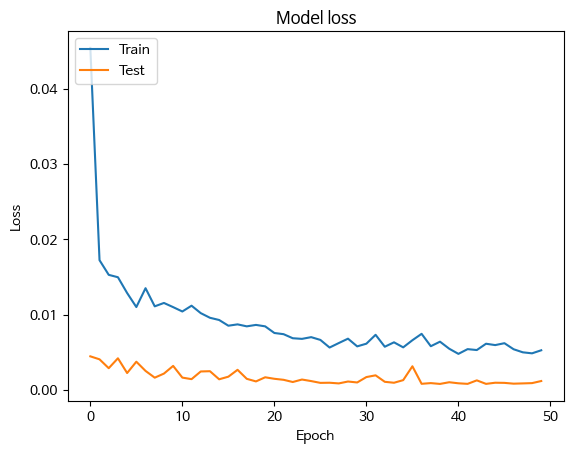

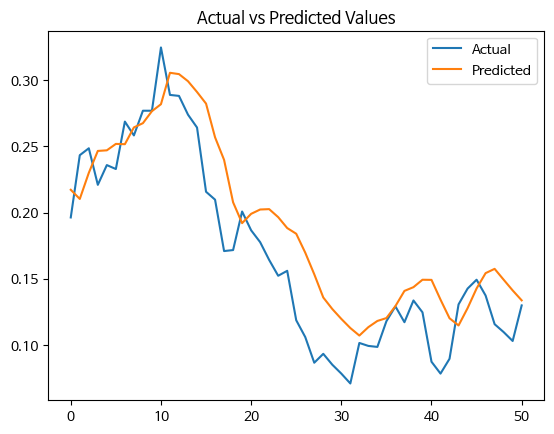

100%|██████████| 1/1 [00:30<00:00, 30.48s/it]


In [16]:
# 각 종목에 대해 반복
unique_codes = result["종목코드"].unique()[:1]
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame(columns=['종목코드', '수익률', '샤프지수'])
for code in tqdm(unique_codes):

    # 훈련 데이터 생성
    train_data = result[result['종목코드'] == code][['일자', '거래량','시가','고가','저가','종가','일일 수익률']]
    train_data['일자'] = pd.to_datetime(train_data['일자'], format='%Y%m%d')
    train_data.set_index('일자', inplace=True)
    train_data = train_data.loc['2021-06-01':'2023-01-30']
    train_values = train_data.values

    # 테스트 데이터
    test_data = result[result['종목코드'] == code][['일자', '거래량','시가','고가','저가','종가','일일 수익률']]
    test_data['일자'] = pd.to_datetime(test_data['일자'], format='%Y%m%d')
    test_data.set_index('일자', inplace=True)
    test_data = test_data.loc['2023-02-01':'2023-05-30']
    test_values = test_data.values

    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_values)
    test_scaled = scaler.transform(test_values)

    # 입력 데이터 사이즈 세팅
    window_size = 30

    # LSTM train, test 데이터 생성
    X_train, y_train = [], []
    for i in range(len(train_scaled) - window_size):
        X_train.append(train_scaled[i:i + window_size])
        y_train.append(train_scaled[i + window_size, 4]) # 종가
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test, y_test = [], []
    for i in range(len(test_scaled) - window_size):
        X_test.append(test_scaled[i:i + window_size])
        y_test.append(test_scaled[i + window_size, 4]) # 종가
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reshape LSTM (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], train_scaled.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], test_scaled.shape[1]))

    # 모델 빌드
    model = Sequential()
    # LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, train_scaled.shape[1])))
    model.add(LSTM(units=50))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # LSTM 생성
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_data = (X_test, y_test))
    # 예측
    predictions = model.predict(X_test)
    # mse
    mse = mean_squared_error(y_test, predictions)
    # 수익률 예측
    final_return = (predictions[-1] - predictions[0]) / predictions[0]
    # 샤프지수
    sharp_index = calculate_sharp(predictions)
    # 결과
    results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
    print("code: ",code,"수익률: ",final_return[0], "mse: ",mse)

    print('training loss:', history.history['loss'][-1])
    print('validation loss:', history.history['val_loss'][-1])

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot actual vs predicted
    plt.figure()
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Actual vs Predicted Values')
    plt.legend()
    plt.show()

In [ ]:
# 각 종목에 대해 반복
unique_codes = result["종목코드"].unique()
# 추론 결과를 저장하기 위한 dataframe 생성
results_df = pd.DataFrame(columns=['종목코드', '수익률', '샤프지수'])
data_len = math.ceil(len(result)*0.8)
for code in tqdm(unique_codes):

    # 훈련 데이터 생성
    train_data = result[result['종목코드'] == code][['일자', '거래량','시가','고가','저가','종가','일일 수익률']]
    train_data['일자'] = pd.to_datetime(train_data['일자'], format='%Y%m%d')
    train_data.set_index('일자', inplace=True)
    train_data = train_data.loc['2021-06-01':'2023-01-30']
    train_values = train_data.values

    # 테스트 데이터
    test_data = result[result['종목코드'] == code][['일자', '거래량','시가','고가','저가','종가','일일 수익률']]
    test_data['일자'] = pd.to_datetime(test_data['일자'], format='%Y%m%d')
    test_data.set_index('일자', inplace=True)
    test_data = test_data.loc['2023-02-01':'2023-05-30']
    test_values = test_data.values

    # 데이터 정규화
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_values)
    test_scaled = scaler.transform(test_values)

    # 입력 데이터 사이즈 세팅
    window_size = 30

    # LSTM train, test 데이터 생성
    X_train, y_train = [], []
    for i in range(len(train_scaled) - window_size):
        X_train.append(train_scaled[i:i + window_size])
        y_train.append(train_scaled[i + window_size, 4]) # 4번째 열 종가
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test, y_test = [], []
    for i in range(len(test_scaled) - window_size):
        X_test.append(test_scaled[i:i + window_size])
        y_test.append(test_scaled[i + window_size, 4]) # 4번째 열 종가
    X_test, y_test = np.array(X_test), np.array(y_test)

    # Reshape LSTM (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], train_scaled.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], test_scaled.shape[1]))

    # 모델 빌드
    model = Sequential()
    # LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=(window_size, train_scaled.shape[1])))
    model.add(LSTM(units=50))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # LSTM 생성
    model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0, validation_data = (X_test, y_test))

    # 예측
    predictions = model.predict(X_test)
    # mse
    mse = mean_squared_error(y_test, predictions)
    # 수익률 예측
    final_return = (predictions[-1] - predictions[0]) / predictions[0]
    # 샤프지수
    sharp_index = calculate_sharp(predictions)
    # 결과
    results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
    print("code: ",code,"수익률: ",final_return[0], "mse: ",mse)

  0%|          | 0/2000 [00:00<?, ?it/s]

2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 1/2000 [00:19<10:53:07, 19.60s/it]

code:  A050110 수익률:  -0.40659073 mse:  0.0009410112887650782
2/2 [==============================] - 1s 12ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 2/2000 [00:45<12:51:33, 23.17s/it]

code:  A066310 수익률:  -0.017738584 mse:  0.00033274089006689344
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 3/2000 [00:59<10:41:42, 19.28s/it]

code:  A289220 수익률:  -0.5984849 mse:  8.924986347335034e-05
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 4/2000 [01:13<9:32:32, 17.21s/it] 

code:  A016090 수익률:  0.11469098 mse:  0.00021995599052394455
2/2 [==============================] - 4s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 5/2000 [01:31<9:31:14, 17.18s/it]

code:  A048550 수익률:  -0.835309 mse:  0.0011408750116491642
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 6/2000 [01:57<11:13:08, 20.26s/it]

code:  A002360 수익률:  -0.8036629 mse:  0.0008864445546458896
2/2 [==============================] - 1s 13ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 7/2000 [02:12<10:16:13, 18.55s/it]

code:  A284740 수익률:  -1.3967643 mse:  0.0023263621647930883
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 8/2000 [02:27<9:35:58, 17.35s/it] 

code:  A214610 수익률:  -0.38061687 mse:  0.0034654075866696714
2/2 [==============================] - 1s 10ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 9/2000 [02:40<8:58:54, 16.24s/it]

code:  A196490 수익률:  3.7465632 mse:  0.003469638000675959
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  0%|          | 10/2000 [02:59<9:26:29, 17.08s/it]

code:  A001740 수익률:  0.3682018 mse:  0.005822090763377768
2/2 [==============================] - 1s 13ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 11/2000 [03:14<9:05:54, 16.47s/it]

code:  A230980 수익률:  1.6000067 mse:  0.0005930331737246364
2/2 [==============================] - 1s 8ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 12/2000 [03:30<8:58:34, 16.25s/it]

code:  A018120 수익률:  0.63062394 mse:  0.0029379914679829693
2/2 [==============================] - 1s 8ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 13/2000 [03:55<10:19:14, 18.70s/it]

code:  A000660 수익률:  1.6424172 mse:  0.004809166259440957
2/2 [==============================] - 3s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 14/2000 [04:11<9:57:16, 18.04s/it] 

code:  A089470 수익률:  0.99319255 mse:  0.0009114893202478275
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 15/2000 [04:28<9:42:02, 17.59s/it]

code:  A131290 수익률:  2.6238015 mse:  0.0016201889217403326
2/2 [==============================] - 1s 11ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 16/2000 [04:42<9:11:30, 16.68s/it]

code:  A320000 수익률:  -0.280491 mse:  0.33225165468735357
2/2 [==============================] - 1s 12ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 17/2000 [05:07<10:32:45, 19.15s/it]

code:  A003000 수익률:  -0.11594523 mse:  0.00034842090272443064
2/2 [==============================] - 1s 13ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 18/2000 [05:21<9:37:49, 17.49s/it] 

code:  A006060 수익률:  -0.50707257 mse:  0.002582559690980599
2/2 [==============================] - 1s 11ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 19/2000 [05:41<10:02:16, 18.24s/it]

code:  A307750 수익률:  0.46309498 mse:  0.0005364296049500555
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 20/2000 [06:06<11:06:52, 20.21s/it]

code:  A153460 수익률:  0.3880832 mse:  0.013211936034650627
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 21/2000 [06:20<10:07:15, 18.41s/it]

code:  A200130 수익률:  -0.73119277 mse:  0.001332868215021086
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 22/2000 [06:34<9:25:57, 17.17s/it] 

code:  A314930 수익률:  0.6523915 mse:  0.00677233070888636
2/2 [==============================] - 1s 12ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 23/2000 [06:47<8:49:20, 16.07s/it]

code:  A037460 수익률:  0.41873452 mse:  0.0007899820075714553
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|          | 24/2000 [07:07<9:20:34, 17.02s/it]

code:  A092190 수익률:  4.4421387 mse:  0.0012303065748380869
2/2 [==============================] - 1s 10ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|▏         | 25/2000 [07:21<8:55:30, 16.27s/it]

code:  A008040 수익률:  1.58513 mse:  0.0004154221355501815
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|▏         | 26/2000 [07:36<8:36:01, 15.68s/it]

code:  A352940 수익률:  -0.110804185 mse:  0.00048469074440215523
2/2 [==============================] - 1s 10ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|▏         | 27/2000 [07:49<8:15:27, 15.07s/it]

code:  A290650 수익률:  1.2673874 mse:  0.0041451739897118735
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|▏         | 28/2000 [08:09<9:00:34, 16.45s/it]

code:  A003460 수익률:  4.780934 mse:  0.003980697009413493
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  1%|▏         | 29/2000 [08:34<10:25:07, 19.03s/it]

code:  A012610 수익률:  0.04043423 mse:  0.002817389568965969
2/2 [==============================] - 1s 12ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 30/2000 [08:51<10:02:29, 18.35s/it]

code:  A208340 수익률:  -0.14672253 mse:  0.0002091304753977006
2/2 [==============================] - 1s 8ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 31/2000 [09:05<9:22:47, 17.15s/it] 

code:  A009270 수익률:  -0.508156 mse:  7.891564013324817e-05
2/2 [==============================] - 1s 12ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 32/2000 [09:19<8:47:19, 16.08s/it]

code:  A032620 수익률:  -0.15618849 mse:  0.0012697336589248436
2/2 [==============================] - 1s 10ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 33/2000 [09:38<9:24:02, 17.21s/it]

code:  A059120 수익률:  -0.005945894 mse:  0.0020954350617661587
2/2 [==============================] - 1s 10ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 34/2000 [09:53<8:59:02, 16.45s/it]

code:  A017550 수익률:  0.2756791 mse:  0.0005572513771809015
2/2 [==============================] - 1s 11ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 35/2000 [10:08<8:39:29, 15.86s/it]

code:  A033500 수익률:  1.077333 mse:  0.004545510125091071
2/2 [==============================] - 1s 14ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 36/2000 [10:22<8:28:39, 15.54s/it]

code:  A052330 수익률:  -0.44503823 mse:  0.004644691067224707
2/2 [==============================] - 1s 13ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 37/2000 [10:47<10:00:52, 18.37s/it]

code:  A041960 수익률:  10.547078 mse:  0.0018060773256805445
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 38/2000 [11:13<11:12:24, 20.56s/it]

code:  A017000 수익률:  -0.16979448 mse:  6.352085095831778e-05
2/2 [==============================] - 1s 9ms/step


<ipython-input-76-79eaa660750f>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'종목코드': code, '수익률': final_return[0], '샤프지수':sharp_index}, ignore_index=True)
  2%|▏         | 39/2000 [11:27<10:10:21, 18.67s/it]

code:  A069260 수익률:  2.3818521 mse:  0.0028545896408387005


  2%|▏         | 39/2000 [11:41<9:47:34, 17.98s/it] 


KeyboardInterrupt: ignored

In [ ]:
results_df["가중평균"] = (results_df["수익률"]*0.5 + results_df["샤프지수"]*0.5) / 2
results_df['순위'] = results_df['가중평균'].rank(method='first', ascending=False).astype('int') # 각 순위를 중복없이 생성
results_df

,종목코드,수익률,샤프지수,가중평균,순위
0,A050110,-0.573573,-0.022867,-0.149110,1182
1,A066310,-1.126748,-0.034490,-0.290310,1441
2,A289220,1.428341,-0.009463,0.354720,482
3,A016090,0.839960,-0.047944,0.198004,631
4,A048550,-0.681131,-0.034069,-0.178800,1246
...,...,...,...,...,...
1995,A015860,-0.915248,0.045146,-0.217525,1331
1996,A065450,-0.555270,-0.039345,-0.148654,1179
1997,A008060,-1.018375,-0.126971,-0.286337,1434
1998,A093240,1.610132,0.090233,0.425091,427


In [ ]:
results_df[results_df["수익률"] >= 100]

,종목코드,수익률,샤프지수
116,A082920,148.928589,0.062971
240,A024850,278.964386,0.097245
574,A005710,843.795654,-0.088963
694,A025770,1112.293579,-0.017729
773,A033340,750.905579,0.073939
830,A363250,176.422318,0.065011
1030,A024830,610.466309,0.063442
1175,A337930,459912.968750,0.066097
1182,A099520,207.657715,0.074550
1377,A175250,413.378723,0.069721


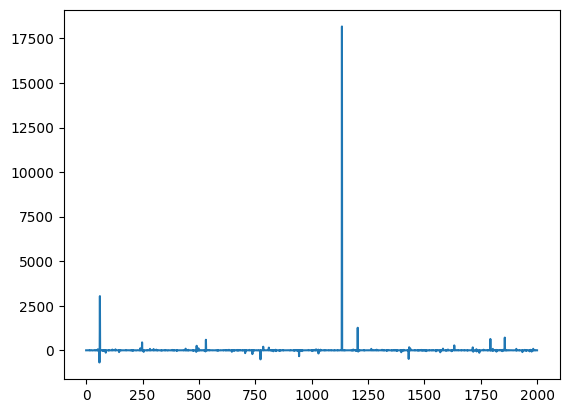

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results_df["수익률"])

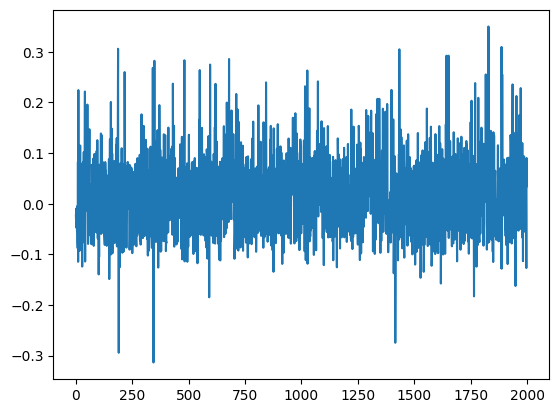

In [ ]:
plt.plot(results_df["샤프지수"])

In [ ]:
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/datasets/result_df2.csv")